# Assignment: Capstone Sprint 2
## Name: Allan Salamanca
## Course: Data Science Diploma Program
## Due Date: April 27, 2025

## Project Objective: Predict Home Price Index (HPI) Based on Major Crime Incidents (MCI) in Toronto

In [385]:
# Import all packages required for the analysis.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import seaborn as sns
import calendar

from scipy.stats import pearsonr
from scipy import stats

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib.ticker import StrMethodFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Approach for Capstone 2

- Data preprocessing - joining all existing data frames.
- Exploratory data analysis on the combined data frame.
- Baseline modelling.
- Next steps.

## Data Preprocessing

#### At the end of Capstone 1, we had cleaned up three data sets, which included the following:
- df_hp: MLS® Home Price Index Archive - The home price index for Toronto is broken down by neighbourhood and property type.
- df_mci: Toronto Police Services Major Crime Indicators Open Data - all logged incidents of major crimes in Toronto, broken down by neighbourhood and crime category.
- df_index: Toronto Home Index - Manually created a table with standardized labelling to join the MLS and Toronto Police neighbourhood data to a Municipality Code.

#### The next step will be to create a consolidated data frame that combines all three tables, which we will use for modelling.

### Preprocessing - MLS® Home Price Index Archive

In [389]:
# Load and prep data frame for the MLS Home Prince Index data.

df_hpi = pd.read_csv('toronto_home_price_index_2015_2024.csv')
df_hpi.head()

,Toronto Municipality,Effective Date,Attribute,Value
0,City of Toronto,2015-01-01,HPI - Single-Family Detached,787300.0
1,City of Toronto,2015-01-01,HPI - Single-Family Attached,625000.0
2,City of Toronto,2015-01-01,HPI - Townhouse,413100.0
3,City of Toronto,2015-01-01,HPI - Apartment,330200.0
4,Toronto W01,2015-01-01,HPI - Single-Family Detached,849400.0


In [390]:
df_hpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Toronto Municipality  17280 non-null  object 
 1   Effective Date        17280 non-null  object 
 2   Attribute             17280 non-null  object 
 3   Value                 16860 non-null  float64
dtypes: float64(1), object(3)
memory usage: 540.1+ KB


#### We can see that the effective date needs to be converted into a date format.  We also want to add a year and month column for analysis.  Additionally, we notice that there are null in the Value column.  For now, we will keep this and address it later in our combined data frame.

#### Since one of our dependent variables is Toronto Municipality (Neighbourhood), I will drop "City of Toronto", as it will not be needed.

In [392]:
# Convert effective date and add year/month columns.

df_hpi['Effective Date'] = pd.to_datetime(df_hpi['Effective Date'])
df_hpi['Year'] = df_hpi['Effective Date'].dt.year
df_hpi['Month'] = df_hpi['Effective Date'].dt.month

In [393]:
# Drop City of Toronto and reindex the data frame.
df_hpi = df_hpi[df_hpi['Toronto Municipality'] != 'City of Toronto']
df_hpi = df_hpi.reset_index(drop=True)

In [394]:
df_hpi.head()

,Toronto Municipality,Effective Date,Attribute,Value,Year,Month
0,Toronto W01,2015-01-01,HPI - Single-Family Detached,849400.0,2015,1
1,Toronto W01,2015-01-01,HPI - Single-Family Attached,677500.0,2015,1
2,Toronto W01,2015-01-01,HPI - Townhouse,415100.0,2015,1
3,Toronto W01,2015-01-01,HPI - Apartment,326300.0,2015,1
4,Toronto W02,2015-01-01,HPI - Single-Family Detached,805300.0,2015,1


In [395]:
df_hpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Toronto Municipality  16800 non-null  object        
 1   Effective Date        16800 non-null  datetime64[ns]
 2   Attribute             16800 non-null  object        
 3   Value                 16380 non-null  float64       
 4   Year                  16800 non-null  int32         
 5   Month                 16800 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(2)
memory usage: 656.4+ KB


#### Now we have a cleaned Home Price Index table.

### Preprocessing - Toronto Police Services Major Crime Indicators Open Data

In [398]:
# Load and prep the Toronto Police Services Major Crime Indicators Open Data.

df_mci = pd.read_csv('toronto_major_crime_indicators_2015_2024.csv')
df_mci.head()

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,x,y
0,69,GO-20141262074,1/1/2014 5:00:00 AM,6/1/1998 5:00:00 AM,2014,January,1,1,Wednesday,12,...,Administering Noxious Thing,Assault,38,Lansing-Westgate (38),38,Lansing-Westgate (38),-79.425412,43.757464,-8.841596e+06,5.427986e+06
1,398,GO-20141292170,1/6/2014 5:00:00 AM,1/31/1996 5:00:00 AM,2014,January,6,6,Monday,13,...,Assault,Assault,47,Don Valley Village (47),47,Don Valley Village (47),-79.359782,43.790043,-8.834291e+06,5.433008e+06
2,1030,GO-20141396749,1/14/2014 5:00:00 AM,1/1/1980 5:00:00 AM,2014,January,14,14,Tuesday,14,...,Assault With Weapon,Assault,NSA,NSA,NSA,NSA,0.000000,0.000000,6.330000e-09,5.660000e-09
3,1031,GO-20141396749,1/14/2014 5:00:00 AM,1/1/1980 5:00:00 AM,2014,January,14,14,Tuesday,14,...,Assault,Assault,NSA,NSA,NSA,NSA,0.000000,0.000000,6.330000e-09,5.660000e-09
4,3345,GO-20141514632,2/12/2014 5:00:00 AM,10/1/1999 5:00:00 AM,2014,February,12,43,Wednesday,8,...,Assault With Weapon,Assault,143,West Rouge (143),131,Rouge (131),-79.132915,43.780413,-8.809036e+06,5.431523e+06


In [399]:
df_mci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386181 entries, 0 to 386180
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECTID           386181 non-null  int64  
 1   EVENT_UNIQUE_ID    386181 non-null  object 
 2   REPORT_DATE        386181 non-null  object 
 3   OCC_DATE           386181 non-null  object 
 4   REPORT_YEAR        386181 non-null  int64  
 5   REPORT_MONTH       386181 non-null  object 
 6   REPORT_DAY         386181 non-null  int64  
 7   REPORT_DOY         386181 non-null  int64  
 8   REPORT_DOW         386181 non-null  object 
 9   REPORT_HOUR        386181 non-null  int64  
 10  OCC_YEAR           386037 non-null  float64
 11  OCC_MONTH          386037 non-null  object 
 12  OCC_DAY            386037 non-null  float64
 13  OCC_DOY            386037 non-null  float64
 14  OCC_DOW            386037 non-null  object 
 15  OCC_HOUR           386181 non-null  int64  
 16  DI

#### Similarly, we want to convert the REPORT_DATE to a date format.  While there are already REPORT_YEAR and REPORT_MONTH, their formats are incorrect.  So, I'll add a column with the correct formatting.

#### Our main column is NEIGHBOURHOOD_140, which has a unique identifier for each neighbourhood.  We can see in the data that there are 'NSA' values, which are null.  We have 386,181 entries, so we'll do a quick check to see how much % are null values. 

In [401]:
# Convert effective date and add year/month columns.

df_mci['REPORT_DATE'] = pd.to_datetime(df_mci['REPORT_DATE'])
df_mci['Year'] = df_mci['REPORT_DATE'].dt.year
df_mci['Month'] = df_mci['REPORT_DATE'].dt.month

In [402]:
# Next, let's check the NSA values to see how much it impacts our data.
nsa_count = (df_mci['HOOD_140'] == 'NSA').sum()
nsa_count

6023

In [403]:
row_total = df_mci['HOOD_140'].notna().sum()
nsa_percent = (nsa_count / row_total) * 100
nsa_percent

1.559631364567392

#### We can see that 'NSA' appears 6,023 times in the HOOD_140 column, which represents about 1.55% of the total data (386,181).  Since this is such a small number, it won't significantly impact our analysis.  Therefore, I'll be dropping these null values.

In [405]:
# Remove the NSA from our dataset.

df_mci = df_mci[df_mci['HOOD_140'] != 'NSA']
df_mci = df_mci.reset_index(drop=True)

In [406]:
df_mci.head()

,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,x,y,Year,Month
0,69,GO-20141262074,2014-01-01 05:00:00,6/1/1998 5:00:00 AM,2014,January,1,1,Wednesday,12,...,38,Lansing-Westgate (38),38,Lansing-Westgate (38),-79.425412,43.757464,-8841596.417,5427985.647,2014,1
1,398,GO-20141292170,2014-01-06 05:00:00,1/31/1996 5:00:00 AM,2014,January,6,6,Monday,13,...,47,Don Valley Village (47),47,Don Valley Village (47),-79.359782,43.790043,-8834290.503,5433008.186,2014,1
2,3345,GO-20141514632,2014-02-12 05:00:00,10/1/1999 5:00:00 AM,2014,February,12,43,Wednesday,8,...,143,West Rouge (143),131,Rouge (131),-79.132915,43.780413,-8809035.842,5431523.169,2014,2
3,3346,GO-20141514632,2014-02-12 05:00:00,10/1/1999 5:00:00 AM,2014,February,12,43,Wednesday,8,...,143,West Rouge (143),131,Rouge (131),-79.132915,43.780413,-8809035.842,5431523.169,2014,2
4,5036,GO-20141635586,2014-03-04 05:00:00,1/1/1989 5:00:00 AM,2014,March,4,63,Tuesday,1,...,60,Woodbine-Lumsden (60),60,Woodbine-Lumsden (60),-79.312393,43.689476,-8829015.207,5417512.886,2014,3


In [407]:
df_mci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380158 entries, 0 to 380157
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   OBJECTID           380158 non-null  int64         
 1   EVENT_UNIQUE_ID    380158 non-null  object        
 2   REPORT_DATE        380158 non-null  datetime64[ns]
 3   OCC_DATE           380158 non-null  object        
 4   REPORT_YEAR        380158 non-null  int64         
 5   REPORT_MONTH       380158 non-null  object        
 6   REPORT_DAY         380158 non-null  int64         
 7   REPORT_DOY         380158 non-null  int64         
 8   REPORT_DOW         380158 non-null  object        
 9   REPORT_HOUR        380158 non-null  int64         
 10  OCC_YEAR           380028 non-null  float64       
 11  OCC_MONTH          380028 non-null  object        
 12  OCC_DAY            380028 non-null  float64       
 13  OCC_DOY            380028 non-null  float64 

#### Now we have a cleaned Toronto Police data table.

### Preprocessing - Toronto Neighbourhood Index

In [410]:
# Load and prep the Toronto Neighbourhood Index

df_index = pd.read_csv('toronto_neighbourhood_index.csv')
df_index.head()

,Toronto Police Neighbourhood Categories,MLS Neighbourhood Categories,MLS Municipality Code
0,Agincourt North (129),Agincourt North,Toronto E07
1,Agincourt South-Malvern West (128),Agincourt South-Malvern West,Toronto E07
2,Alderwood (20),Alderwood,Toronto W06
3,Annex (95),Annex,Toronto C02
4,Banbury-Don Mills (42),Banbury-Don Mills,Toronto C13


In [411]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Toronto Police Neighbourhood Categories  140 non-null    object
 1   MLS Neighbourhood Categories             140 non-null    object
 2   MLS Municipality Code                    140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


#### Since this data was manually created, it is already clean.  Column 0 maps to the Toronto Police data, and column 2 maps to the MLS data.

### Preprocessing - Combining All Three Data Frames

#### My main data frame will be df_hpi because it contains home property values by property type, neighbourhood, and date.  Therefore, I need to add a column that sums the crime count data from the df_mci based on the neighbourhood and date.

#### First, I will add the MLS Neighbourhood Categories and MLS Municipality Code from df_index to df_mci.

In [415]:
# Add the neighbourhood index to the Toronto Police data.

df_mci = df_mci.merge(
    df_index[['Toronto Police Neighbourhood Categories', 'MLS Neighbourhood Categories', 'MLS Municipality Code']],
    left_on='NEIGHBOURHOOD_140',
    right_on='Toronto Police Neighbourhood Categories',
    how='left'
)

#### Next, we can notice that there are multiple neighbourhoods assigned to each MLS Municipality Code.  We can create a helper column that summarizes these neighbourhoods, so we can easily see which neighbourhoods are below a municipality.

In [417]:
### Create a data frame to summarize the neighbourhood to MLS municipality code.

neighbourhoods = df_mci.groupby('MLS Municipality Code')['MLS Neighbourhood Categories'] \
    .agg(lambda x: ', '.join(sorted(set(x)))) \
    .reset_index(name='Neighbourhoods')

In [418]:
neighbourhoods.head()

,MLS Municipality Code,Neighbourhoods
0,Toronto C01,"Bay Street Corridor, Dufferin Grove, Kensingto..."
1,Toronto C02,"Annex, Casa Loma, Wychwood, Yonge-St.Clair"
2,Toronto C03,"Forest Hill South, Humewood-Cedarvale, Oakwood..."
3,Toronto C04,"Bedford Park-Nortown, Englemount-Lawrence, For..."
4,Toronto C06,"Bathurst Manor, Clanton Park"


#### While this data won't be used in our modelling, we can reference it later to add a neighbourhood label to our finished product for Sprint 3.

#### Next, let's create a summary of df_mci to group the crime count by MLS Municipality Code, Year, and Month.

In [420]:
df_mci_summary = df_mci.groupby(
    ['MLS Municipality Code', 'Year', 'Month']
).size().reset_index(name='Crime Count')

In [421]:
df_mci_summary

,MLS Municipality Code,Year,Month,Crime Count
0,Toronto C01,2014,9,1
1,Toronto C01,2014,12,1
2,Toronto C01,2015,1,299
3,Toronto C01,2015,2,241
4,Toronto C01,2015,3,269
...,...,...,...,...
4208,Toronto W10,2024,8,213
4209,Toronto W10,2024,9,177
4210,Toronto W10,2024,10,159
4211,Toronto W10,2024,11,200


In [422]:
# Let's do a quick check to make sure the crime count matches our total records.

df_mci_summary['Crime Count'].sum()

380158

#### Now that we've created a Crime Count table, we can merge this with the df_hpi to create a main data frame.

In [424]:
# Add the Crime count to the MLS Home Price Index table.

df = df_hpi.merge(
    df_mci_summary,
    left_on=['Toronto Municipality', 'Year', 'Month'],
    right_on=['MLS Municipality Code', 'Year', 'Month'],
    how='left'
)

In [425]:
# Drop the redundant columns
df = df.drop(columns=['MLS Municipality Code'])

In [426]:
df.head()

,Toronto Municipality,Effective Date,Attribute,Value,Year,Month,Crime Count
0,Toronto W01,2015-01-01,HPI - Single-Family Detached,849400.0,2015,1,44
1,Toronto W01,2015-01-01,HPI - Single-Family Attached,677500.0,2015,1,44
2,Toronto W01,2015-01-01,HPI - Townhouse,415100.0,2015,1,44
3,Toronto W01,2015-01-01,HPI - Apartment,326300.0,2015,1,44
4,Toronto W02,2015-01-01,HPI - Single-Family Detached,805300.0,2015,1,62


#### Now, let's create the dummy variables for our categorical columns, which are Toronto Municipality and Attribute.

In [428]:
# Create a dummy data frame.

categories = ["Attribute", "Toronto Municipality"]
dummies = pd.get_dummies(df[categories]).astype('int64')

In [429]:
# Create an updated data frame with the dummy variables.

df_v1 = pd.concat(
    [df[[ "Year", "Month", "Effective Date", "Value", "Crime Count"]], dummies],
    axis=1
)

In [430]:
df_v1.head()

,Year,Month,Effective Date,Value,Crime Count,Attribute_HPI - Apartment,Attribute_HPI - Single-Family Attached,Attribute_HPI - Single-Family Detached,Attribute_HPI - Townhouse,Toronto Municipality_Toronto C01,...,Toronto Municipality_Toronto W01,Toronto Municipality_Toronto W02,Toronto Municipality_Toronto W03,Toronto Municipality_Toronto W04,Toronto Municipality_Toronto W05,Toronto Municipality_Toronto W06,Toronto Municipality_Toronto W07,Toronto Municipality_Toronto W08,Toronto Municipality_Toronto W09,Toronto Municipality_Toronto W10
0,2015,1,2015-01-01,849400.0,44,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2015,1,2015-01-01,677500.0,44,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2015,1,2015-01-01,415100.0,44,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,2015,1,2015-01-01,326300.0,44,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2015,1,2015-01-01,805300.0,62,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [431]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Year                                    16800 non-null  int32         
 1   Month                                   16800 non-null  int32         
 2   Effective Date                          16800 non-null  datetime64[ns]
 3   Value                                   16380 non-null  float64       
 4   Crime Count                             16800 non-null  int64         
 5   Attribute_HPI - Apartment               16800 non-null  int64         
 6   Attribute_HPI - Single-Family Attached  16800 non-null  int64         
 7   Attribute_HPI - Single-Family Detached  16800 non-null  int64         
 8   Attribute_HPI - Townhouse               16800 non-null  int64         
 9   Toronto Municipality_Toronto C01        16800 non-

#### Now, we need to address the null values in column 3.  When we examine the raw data, we notice that there are extended periods, lasting multiple months, during which values are missing.  To address this, I will use the K-Nearest Neighbours algorithm to impute some of the missing data.  Since I want good, smooth data for at least a year, I will use K = 12.

In [433]:
# Separate the non-numeric values first.

non_numeric   = ['Effective Date']
numeric_cols  = df_v1.columns.difference(non_numeric)

X_numeric     = df_v1[numeric_cols]
X_non_numeric = df_v1[non_numeric]

In [434]:
# Create a KNN pipeline, with a scaler.

knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('impute', KNNImputer(
        n_neighbors=12,          
        weights='distance'      
    ))
])

In [435]:
# Fit the data to the pipeline.

X_imputed = knn_pipe.fit_transform(X_numeric)

In [436]:
# Add the columns.

X_imputed = pd.DataFrame(X_imputed,
                         columns=numeric_cols,
                         index=df_v1.index)

In [437]:
# Combine the imputed data with the non-numeric data.

df_v2_knn = pd.concat([X_non_numeric, X_imputed], axis=1)

In [438]:
# Add a column to identify which data was imputed for future reference.

df_v2_knn['Imputed Flag'] = df_v1['Value'].isna().astype(int)

In [439]:
# Revert the scaled data to its original form.

scaler = knn_pipe.named_steps['scale']
X_original = scaler.inverse_transform(X_imputed)
df_v2_knn[numeric_cols] = X_original  

In [440]:
df_v2_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Effective Date                          16800 non-null  datetime64[ns]
 1   Attribute_HPI - Apartment               16800 non-null  float64       
 2   Attribute_HPI - Single-Family Attached  16800 non-null  float64       
 3   Attribute_HPI - Single-Family Detached  16800 non-null  float64       
 4   Attribute_HPI - Townhouse               16800 non-null  float64       
 5   Crime Count                             16800 non-null  float64       
 6   Month                                   16800 non-null  float64       
 7   Toronto Municipality_Toronto C01        16800 non-null  float64       
 8   Toronto Municipality_Toronto C02        16800 non-null  float64       
 9   Toronto Municipality_Toronto C03        16800 non-

In [441]:
print(df_v1['Value'].isna().sum(), '→', df_v2_knn['Value'].isna().sum(),
      'missing values after KNN')

420 → 0 missing values after KNN


#### Now we can see that the null values have been fixed.  Next we can proceed with the EDA on this new data frame.

## Exploratory Data Analysis

#### Our dependent variable is 'Value', and we need to see it's reltionship to our choosen independent variables, which are: Attribute (Property Type), Toronto Municipality, Crime Count and Year.

In [445]:
# Copy and create a v3 data frame.

df_v3 = df_v2_knn.copy()

In [446]:
# Quickly see the distribution and ranges of the data set.

df_v3.describe().T

,count,mean,min,25%,50%,75%,max,std
Effective Date,16800,2019-12-16 10:47:59.999999744,2015-01-01 00:00:00,2017-06-23 12:00:00,2019-12-16 12:00:00,2022-06-08 12:00:00,2024-12-01 00:00:00,NaN
Attribute_HPI - Apartment,16800.0,0.25,0.0,0.0,0.0,0.25,1.0,0.433026
Attribute_HPI - Single-Family Attached,16800.0,0.25,0.0,0.0,0.0,0.25,1.0,0.433026
Attribute_HPI - Single-Family Detached,16800.0,0.25,0.0,0.0,0.0,0.25,1.0,0.433026
Attribute_HPI - Townhouse,16800.0,0.25,0.0,0.0,0.0,0.25,1.0,0.433026
Crime Count,16800.0,90.508571,4.0,48.0,67.0,100.0,509.0,76.21937
Month,16800.0,6.5,1.0,3.75,6.5,9.25,12.0,3.452155
Toronto Municipality_Toronto C01,16800.0,0.028571,0.0,0.0,0.0,0.0,1.0,0.166604
Toronto Municipality_Toronto C02,16800.0,0.028571,0.0,0.0,0.0,0.0,1.0,0.166604
Toronto Municipality_Toronto C03,16800.0,0.028571,0.0,0.0,0.0,0.0,1.0,0.166604


#### Let's plot our independent variable against our dependent variable.

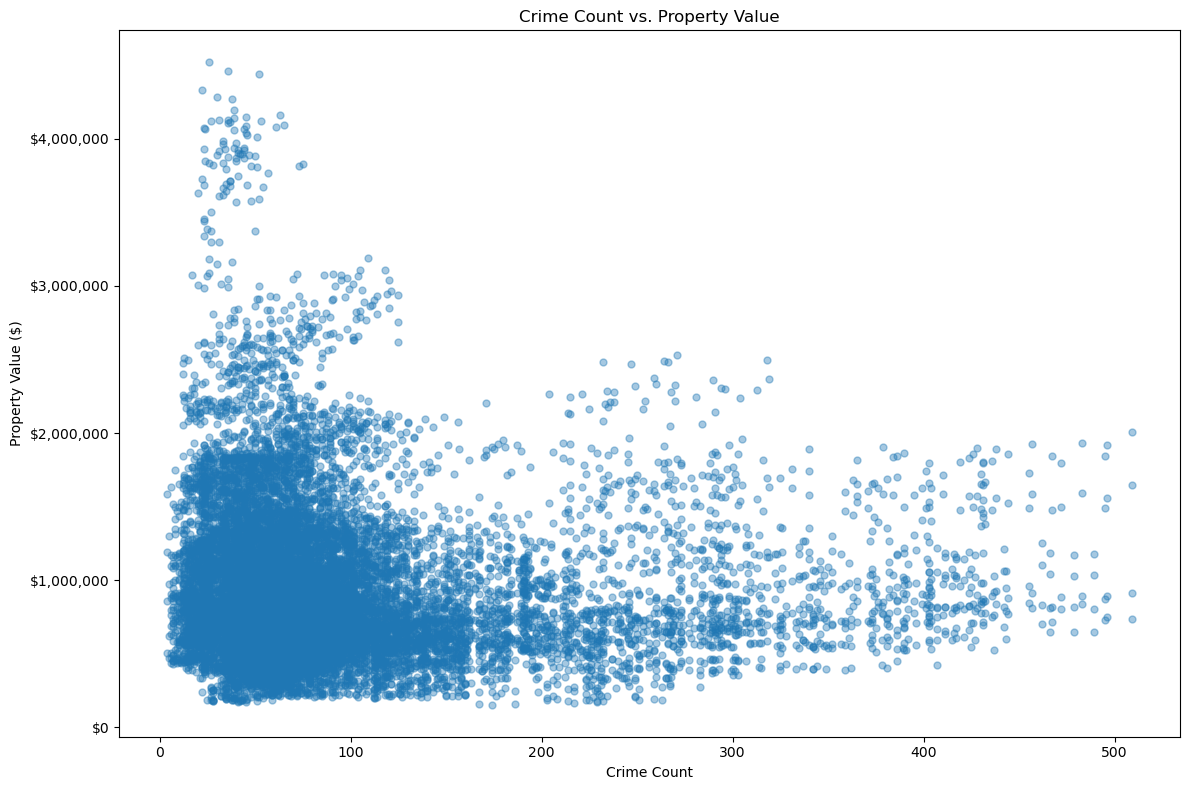

In [448]:
# Crime Count vs Value

plt.figure(figsize=(12, 8))
plt.scatter(
    df_v3["Crime Count"],
    df_v3["Value"],
    alpha=0.4,
    s=25,
)

plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
plt.xlabel("Crime Count")
plt.ylabel("Property Value ($)")
plt.title("Crime Count vs. Property Value")
plt.tight_layout()
plt.show()

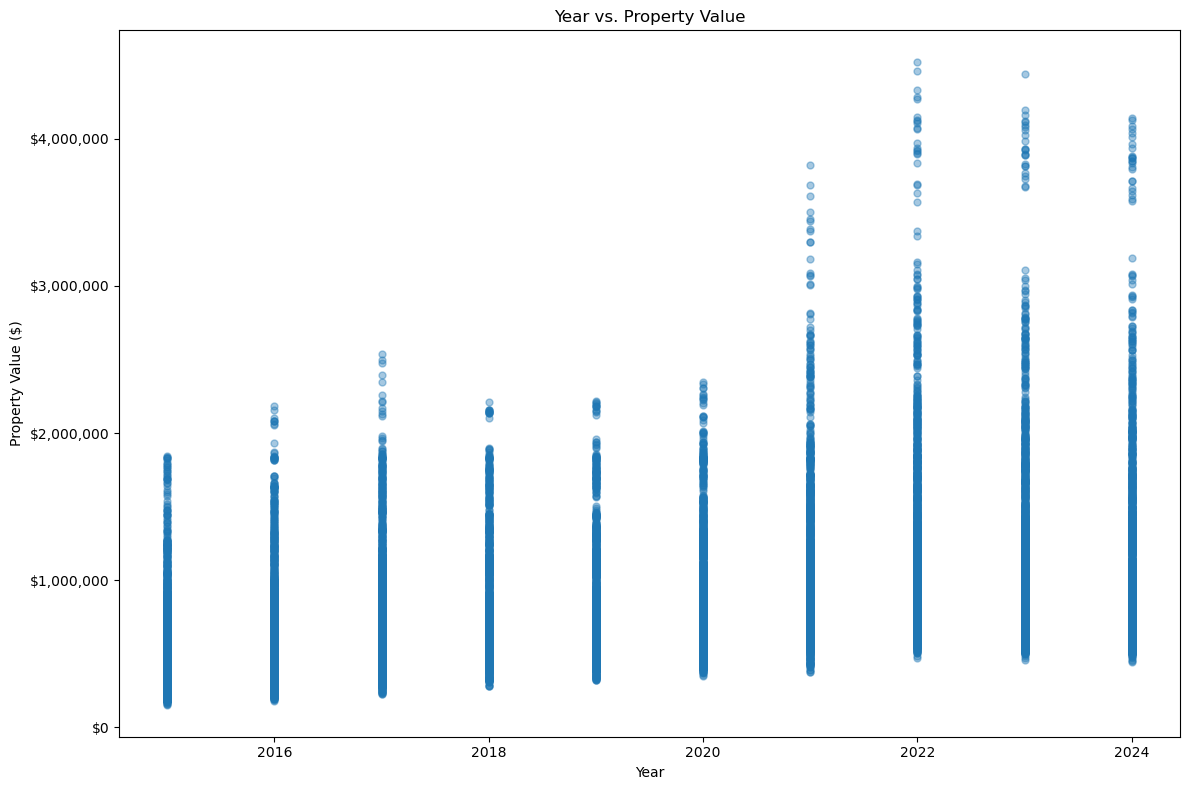

In [449]:
# Year vs Value

plt.figure(figsize=(12, 8))
plt.scatter(
    df_v3["Year"],      
    df_v3["Value"],     
    alpha=0.4,
    s=25,
)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
plt.xlabel("Year")
plt.ylabel("Property Value ($)")
plt.title("Year vs. Property Value")
plt.tight_layout()
plt.show()

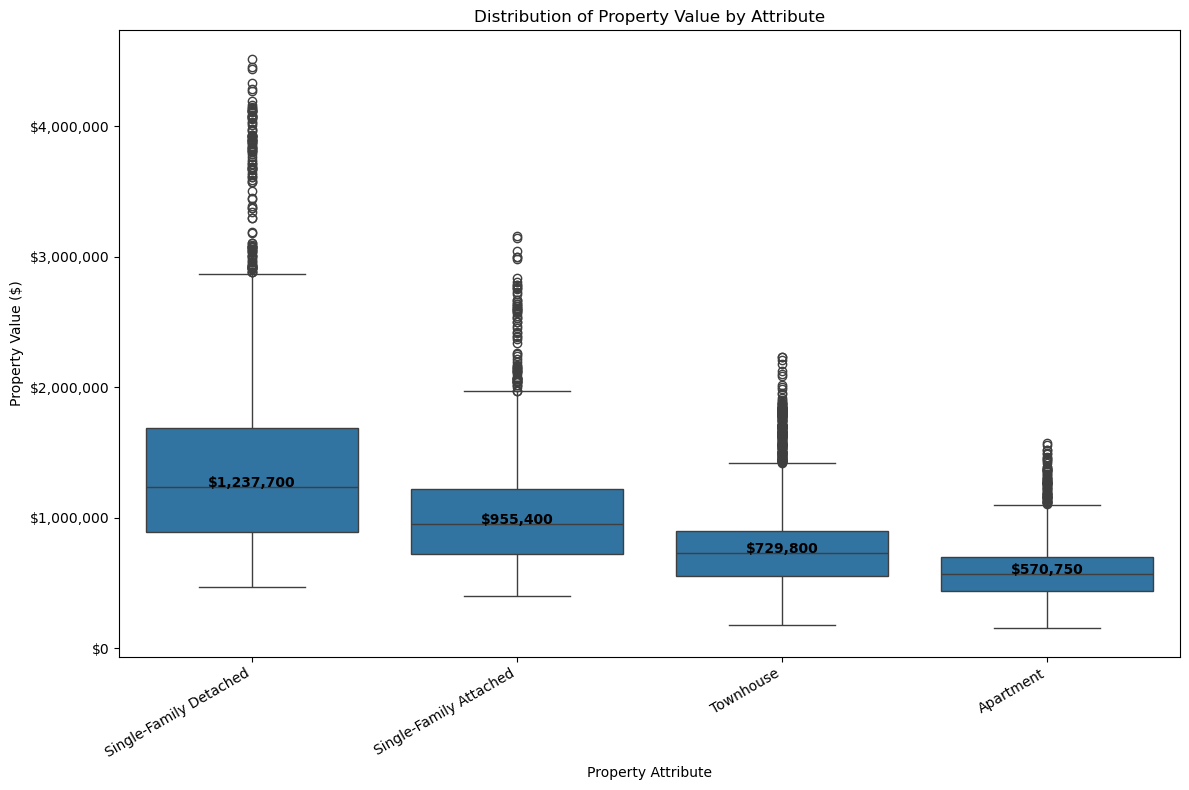

In [450]:
# Attribute vs. Property Value

# Summarize the dummy column into a single column.
attr_cols = [c for c in df_v3 if c.startswith("Attribute_HPI")]
df_v3["Attribute"] = (
    df_v3[attr_cols]
    .idxmax(axis=1)                          
    .str.replace("Attribute_HPI - ", "", regex=False)
)

plt.figure(figsize=(12, 8))
ax = sns.boxplot(
    data=df_v3,
    x="Attribute",
    y="Value"
)

plt.xticks(rotation=30, ha="right")
plt.xlabel("Property Attribute")
plt.ylabel("Property Value ($)")
plt.title("Distribution of Property Value by Attribute")

# Format y-axis as currency
ax.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))

# Add data labels.
xticks = [t.get_text() for t in ax.get_xticklabels()]
medians = df_v3.groupby("Attribute")["Value"].median()

for xtick, label in enumerate(xticks):
    median = medians[label]
    ax.text(
        xtick, median, f"${median:,.0f}",
        horizontalalignment='center',
        size='medium',
        color='black',
        weight='semibold'
    )

plt.tight_layout()
plt.show()

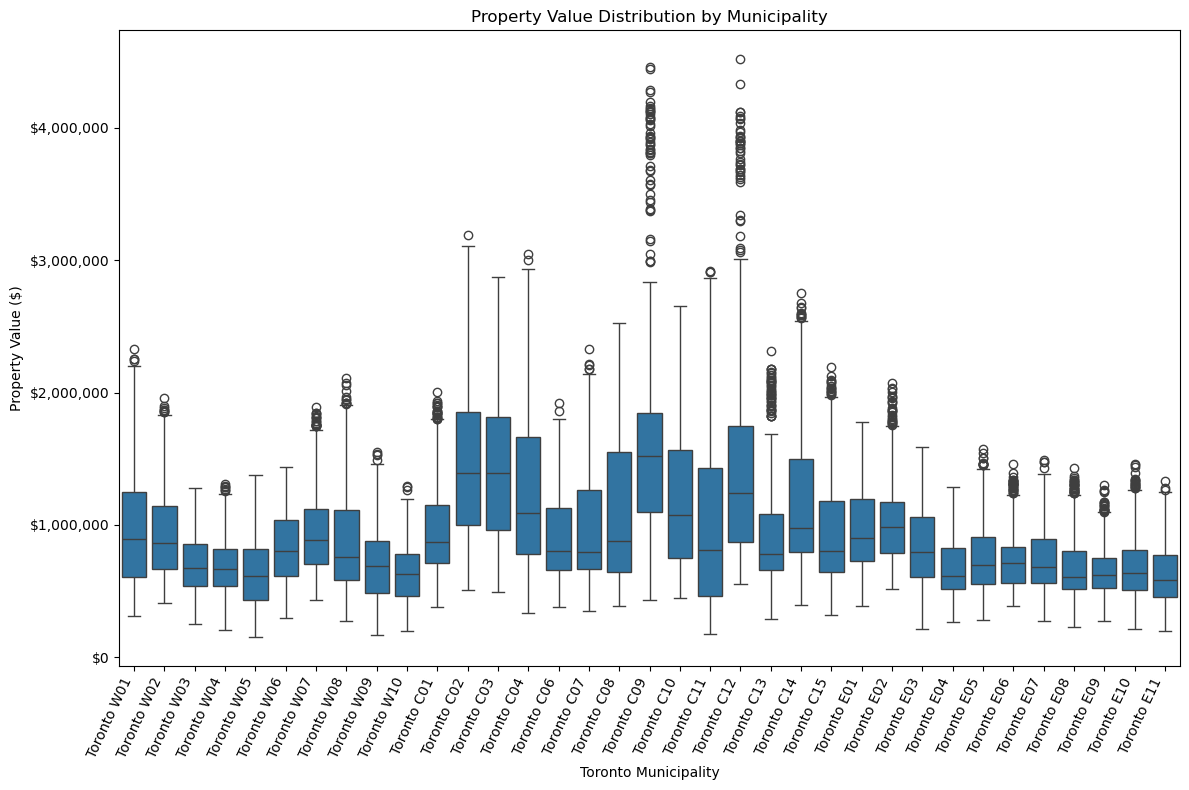

In [451]:
# Municipality vs. Property Value

# Summarize the dummy column into a single column.
muni_cols = [c for c in df_v2_knn if c.startswith("Toronto Municipality")]
df_v3["Municipality"] = (
    df_v3[muni_cols]
    .idxmax(axis=1)
    .str.replace("Toronto Municipality_", "", regex=False)
)

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_v3,
    x="Municipality",
    y="Value"
)

plt.xticks(rotation=65, ha="right")
plt.xlabel("Toronto Municipality")
plt.ylabel("Property Value ($)")
plt.title("Property Value Distribution by Municipality")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
plt.tight_layout()
plt.show()

#### As a general observation, we can see that relationships exist between our dependent and independent variables.  We can see that property values are generally higher in areas with lower crime rates. However, this doesn't necessarily mean lower-valued properties don't exist in low-crime areas.  We do see that areas with higher crime rates have less high-value properties.  When looking at the year, we can see a pattern where property values have been increasing over time.  Lastly, we can see that Attributes and Toronto Municipality influence property values.

#### Next, let's check if there is a multicollinearity issue with our independent variables.

In [453]:
df_v3.head()

,Effective Date,Attribute_HPI - Apartment,Attribute_HPI - Single-Family Attached,Attribute_HPI - Single-Family Detached,Attribute_HPI - Townhouse,Crime Count,Month,Toronto Municipality_Toronto C01,Toronto Municipality_Toronto C02,Toronto Municipality_Toronto C03,...,Toronto Municipality_Toronto W06,Toronto Municipality_Toronto W07,Toronto Municipality_Toronto W08,Toronto Municipality_Toronto W09,Toronto Municipality_Toronto W10,Value,Year,Imputed Flag,Attribute,Municipality
0,2015-01-01,0.0,0.0,1.0,0.0,44.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,849400.0,2015.0,0,Single-Family Detached,Toronto W01
1,2015-01-01,0.0,1.0,0.0,0.0,44.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,677500.0,2015.0,0,Single-Family Attached,Toronto W01
2,2015-01-01,0.0,0.0,0.0,1.0,44.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,415100.0,2015.0,0,Townhouse,Toronto W01
3,2015-01-01,1.0,0.0,0.0,0.0,44.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,326300.0,2015.0,0,Apartment,Toronto W01
4,2015-01-01,0.0,0.0,1.0,0.0,62.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,805300.0,2015.0,0,Single-Family Detached,Toronto W02


In [454]:
# Let's create an updated data frame with the specific columns that we want.
df_v4 = df_v3.copy()
df_v4= df_v4.drop(["Effective Date", "Imputed Flag", "Attribute","Municipality"], axis=1)

In [455]:
df_v4.head()

,Attribute_HPI - Apartment,Attribute_HPI - Single-Family Attached,Attribute_HPI - Single-Family Detached,Attribute_HPI - Townhouse,Crime Count,Month,Toronto Municipality_Toronto C01,Toronto Municipality_Toronto C02,Toronto Municipality_Toronto C03,Toronto Municipality_Toronto C04,...,Toronto Municipality_Toronto W03,Toronto Municipality_Toronto W04,Toronto Municipality_Toronto W05,Toronto Municipality_Toronto W06,Toronto Municipality_Toronto W07,Toronto Municipality_Toronto W08,Toronto Municipality_Toronto W09,Toronto Municipality_Toronto W10,Value,Year
0,0.0,0.0,1.0,0.0,44.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,849400.0,2015.0
1,0.0,1.0,0.0,0.0,44.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,677500.0,2015.0
2,0.0,0.0,0.0,1.0,44.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415100.0,2015.0
3,1.0,0.0,0.0,0.0,44.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326300.0,2015.0
4,0.0,0.0,1.0,0.0,62.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805300.0,2015.0


In [456]:
# Create the correlation matrix table.
corr = df_v4.corr()

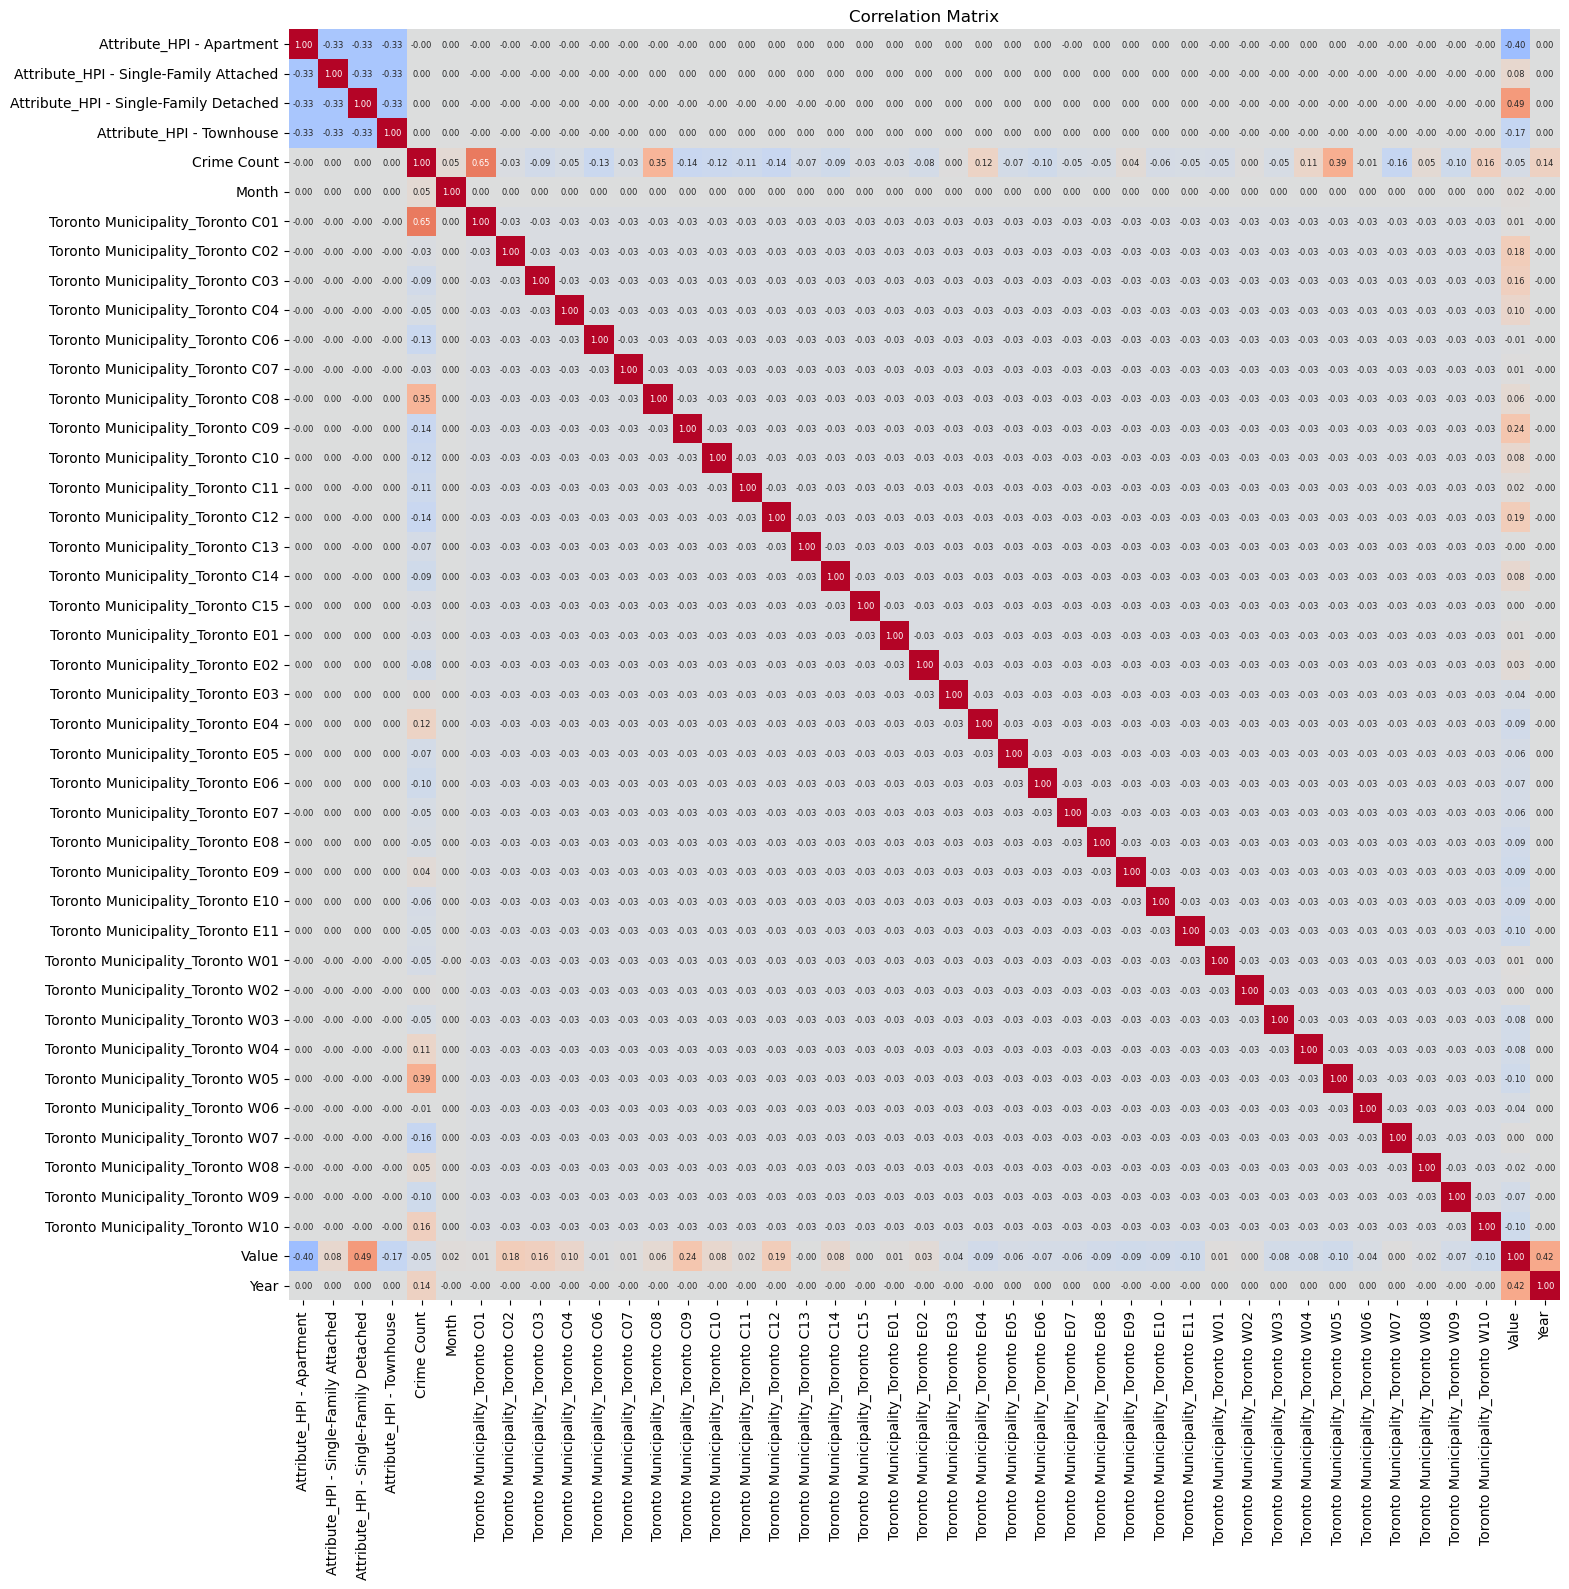

In [457]:
# Plot the correlation matrix.

plt.figure(figsize=(30, 16))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,        # <── show the numbers
    fmt=".2f",         # two decimals
    annot_kws={"size": 6},   # smaller font so they fit
    cbar=False
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### We can see in the matrix that most values are below 0.5, except for one.  The Toronto Municipality (C01) shows a 0.65 correlation with crime counts; however, the correlation with property values is -0.05.  This makes sense since it's a highly dense area downtown, primarily consisting of apartments.  For now, I am keeping it in my model.  Additionally, I will drop the month column and use the Year, as it has a stronger correlation with property values.

#### Now, I'll update my data frame, and we can start fitting our linear regression.

## Modelling - Logistic Regression

In [460]:
df_v5 = df_v4.copy()
df_v5= df_v5.drop(["Month"], axis=1)

In [461]:
df_v5.head()

,Attribute_HPI - Apartment,Attribute_HPI - Single-Family Attached,Attribute_HPI - Single-Family Detached,Attribute_HPI - Townhouse,Crime Count,Toronto Municipality_Toronto C01,Toronto Municipality_Toronto C02,Toronto Municipality_Toronto C03,Toronto Municipality_Toronto C04,Toronto Municipality_Toronto C06,...,Toronto Municipality_Toronto W03,Toronto Municipality_Toronto W04,Toronto Municipality_Toronto W05,Toronto Municipality_Toronto W06,Toronto Municipality_Toronto W07,Toronto Municipality_Toronto W08,Toronto Municipality_Toronto W09,Toronto Municipality_Toronto W10,Value,Year
0,0.0,0.0,1.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,849400.0,2015.0
1,0.0,1.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,677500.0,2015.0
2,0.0,0.0,0.0,1.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415100.0,2015.0
3,1.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326300.0,2015.0
4,0.0,0.0,1.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805300.0,2015.0


In [462]:
# Linear regression, fit data.

attr_cols  = [c for c in df_v5 if c.startswith('Attribute')]
muni_cols  = [c for c in df_v5 if c.startswith('Toronto Municipality')]

X = df_v5[attr_cols + muni_cols + ['Crime Count',"Year"]]
X = sm.add_constant(X)
y = df_v5['Value']

model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1450.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:19:36   Log-Likelihood:            -2.3219e+05
No. Observations:               16800   AIC:                         4.645e+05
Df Residuals:                   16760   BIC:                         4.648e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

#### In general, we have a good R-squared value at 0.77%, which explains most of our variance.  Another thing we notice is that there are no p-values > 0.05.  We can continue working on this model.

#### Next, let's take a look at our residuals to see if it's they are normally distributed.

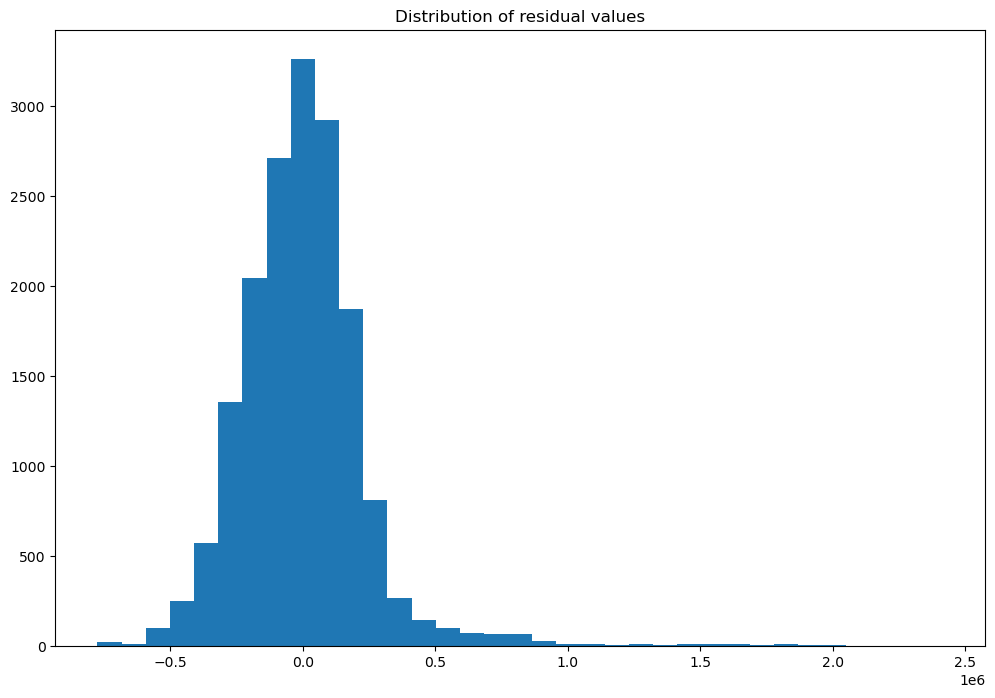

In [464]:
# Plotting the residuals for model1.

plt.figure(figsize=(12, 8))
plt.hist(model1.resid, bins = 35)
plt.title('Distribution of residual values')
plt.show()

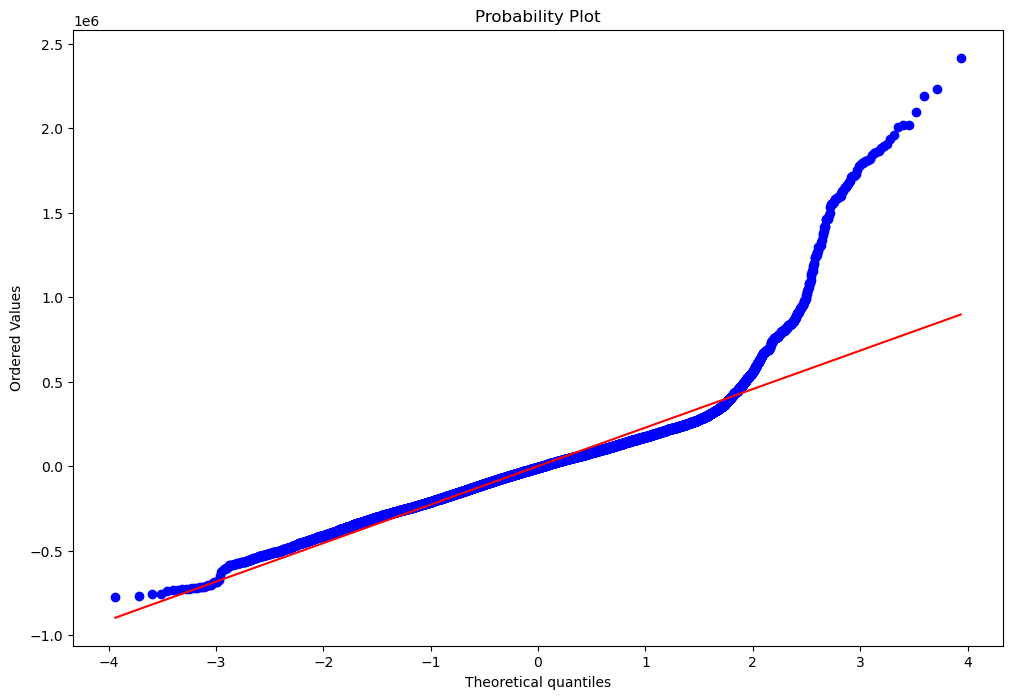

In [465]:
# Normal Q-Q plot

plt.figure(figsize=(12, 8))
stats.probplot(model1.resid, dist="norm", plot=plt)
plt.show()

#### We notice that even though the residuals are normally distributed, it is screwed (positive) at the right tail.  We also see in our Q plot that our model under-predicts high-value homes.

#### Next, let's check for Homoscedasticity or Heteroscedasticity.

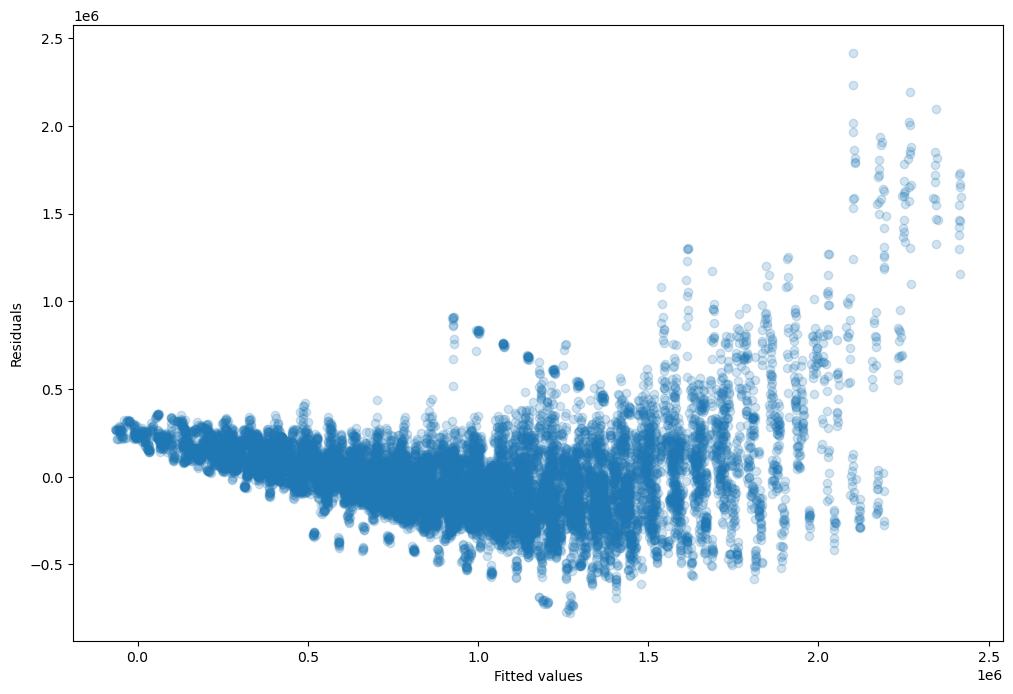

In [467]:
# Plot the residuals and the predicted values

plt.figure(figsize=(12, 8))
plt.scatter(model1.fittedvalues, model1.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

#### Here, we can see that our model exhibits heteroscedasticity, indicating it is not consistent across the dataset.  We see that variances are increasing the value of housing prices.  This confirms our residual and Q-plot results.



#### Next, let's look at how the data performs using Scikit Learn's Linear Regression model.

In [470]:
# Create train and test split.

attr_cols  = [c for c in df_v5 if c.startswith('Attribute')]
muni_cols  = [c for c in df_v5 if c.startswith('Toronto Municipality')]

X2 = df_v5[attr_cols + muni_cols + ['Crime Count',"Year"]]
X2 = sm.add_constant(X2)
y2 = df_v5['Value']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [471]:
# Create a pipeline to scale and fit the model.

pipe = make_pipeline(
    StandardScaler(),      
    LinearRegression()     
)

pipe.fit(X2_train, y2_train)
y2_train_pred = pipe.predict(X2_train)
y2_test_pred  = pipe.predict(X2_test)

# Review test and train score.
train_r2 = r2_score(y2_train, y2_train_pred)
test_r2  = r2_score(y2_test,  y2_test_pred)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y2_test, y2_test_pred))
mae  = mean_absolute_error(y2_test, y2_test_pred)

# Print results.
print(f"Train R² : {train_r2: .2%}")
print(f"Test  R² : {test_r2 : .2%}")
print(f"Test RMSE: {rmse:,.0f}")
print(f"Test  MAE: {mae :,.0f}")

Train R² :  77.06%
Test  R² :  77.40%
Test RMSE: 246,819
Test  MAE: 166,915


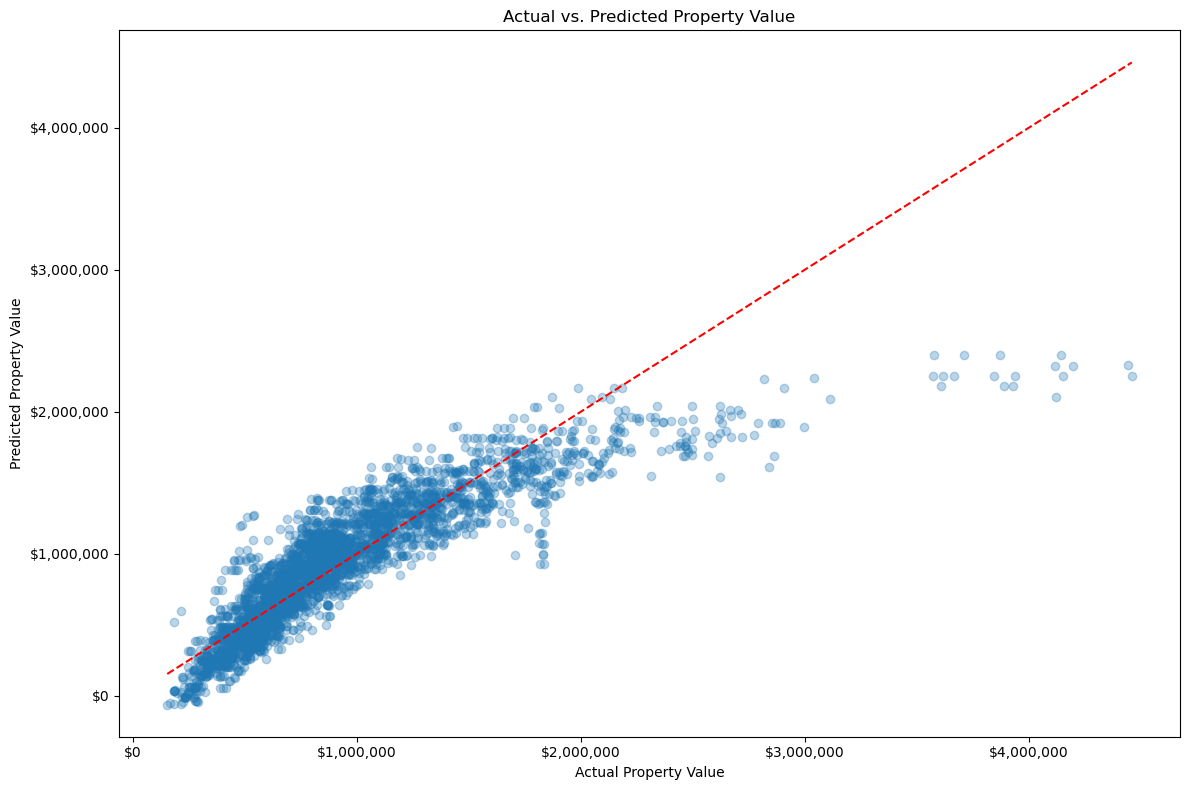

In [472]:
# Plot to visualize the results.

plt.figure(figsize=(12, 8))
plt.scatter(y2_test, y2_test_pred, alpha=0.3)

# Line for "perfect prediction"
plt.plot([y2_test.min(), y2_test.max()],
         [y2_test.min(), y2_test.max()],'r--')

plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs. Predicted Property Value")
fmt = StrMethodFormatter("${x:,.0f}")     # e.g. $1,234,567
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.tight_layout()
plt.show()

#### Our model from Scikit-learn, even when scaled, yields results that are very similar to those of our initial linear regression model.  It confirms that our model doesn't do a good job at predicting high-value properties, and it generally under-predicts them.

#### While our accuracy score is 77%, we notice a significant range in our RMSE and MAE scores.  For our model to be more accurate, we need to understand the outliers that impact the RMSE and MAE. 

## Next Steps

#### Our current model struggles with high property values.  We notice this in values over $ 2 million.  Since we know that some of our independent variables have a higher influence on our dependent variable (Attribute & Municipality), we need to account for these in our advanced modelling.  Additionally, since property values have a wide range, we can consider scaling the data using a Log, using a percentage change in house price instead.  Logging “shrinks” the extreme values so the model focuses on the majority instead of the outliers.

#### Next Steps:
- Log Housing Price Values
- Compare and asses more advanced modelling, such as RandromForestRegressor, DecisionTreeRegressor or XGBoost.
- 
Hyperparameter Tuning.
